In [1]:
# Imports
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path: sys.path.insert(0, project_root)

from src import *
import scipy.sparse.linalg as spsl
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
# Algorithm Parameters
max_energy_level = 3
kd_ratio = 2.5
noise_threshold = 1e-4
epsilon = 1e-5
K_values = list(range(0,800,20))
delta_t = 0.37
num_trials = 20

# Hamiltonian Parameters
molecule = 'N 0.000  0.000  -0.549; N 0.000  0.000  0.549;'
basis_set = 'sto-3g'
mapper = 'parity'

In [3]:
# Generate Hamiltonian and get true eigenenergies
hamiltonian = molecular_hamiltonian(molecule,basis_set,mapper,freeze_core=True)
sparse_hamiltonian = hamiltonian.to_matrix(sparse = True)
num_qubits = hamiltonian.num_qubits

v, w = spsl.eigsh(sparse_hamiltonian,k=20,which = 'SA')
true_eigenenergies = np.unique(np.round(v,8))[:max_energy_level+1]

In [4]:
# Construct reference state
indices = np.argsort(sparse_hamiltonian.diagonal())
reference_state = bitstring_superposition_state(num_qubits,[bin(indices[i])[2:] for i in [0,1,2,2,3,4,5]])

# Get evolved reference states
max_K = K_values[-1]
max_d = int(max_K/kd_ratio)
time_evolution_operator = -1j*sparse_hamiltonian*delta_t
evolved_reference_states = spsl.expm_multiply(time_evolution_operator,reference_state,start=0,stop=max_d+max_K+1,num = max_d+max_K+2)

In [5]:
# Get MODMD observables
pauli_strings, coeffs = zip(*sorted(hamiltonian.to_list(), key = lambda x: np.abs(np.real(x[1])), reverse = True))

modmd_observables = ([SparsePauliOp('I' * num_qubits).to_matrix(sparse=True)] + 
                     [SparsePauliOp(p).to_matrix(sparse=True) for p in pauli_strings[30:36]])

In [6]:
# ODMD Results
odmd_observables = [SparsePauliOp('I' * num_qubits).to_matrix(sparse=True)]
odmd_results = []

X_elements = generate_X_elements(odmd_observables,max_d,max_K,reference_state,evolved_reference_states)

for trial in range(num_trials):
    
    gaussian_noise = np.random.normal(0,epsilon,size=X_elements.shape) + 1j * np.random.normal(0,epsilon,size=X_elements.shape)
    noisy_X_elements = X_elements + gaussian_noise

    odmd_results.append(varying_K_results(len(odmd_observables),noise_threshold,noisy_X_elements,delta_t,K_values,kd_ratio,max_energy_level))

In [7]:
# MODMD Results
modmd_results = []

X_elements = generate_X_elements(modmd_observables,max_d,max_K,reference_state,evolved_reference_states)

for trial in range(num_trials):
    
    gaussian_noise = np.random.normal(0,epsilon,size=X_elements.shape) + 1j * np.random.normal(0,epsilon,size=X_elements.shape)
    noisy_X_elements = X_elements + gaussian_noise

    modmd_results.append(varying_K_results(len(modmd_observables),noise_threshold,noisy_X_elements,delta_t,K_values,kd_ratio,max_energy_level))

In [8]:
# Compute errors
absolute_odmd_errors = np.array([np.abs(odmd_results[i] - true_eigenenergies) for i in range(num_trials)])
absolute_modmd_errors = np.array([np.abs(modmd_results[i] - true_eigenenergies) for i in range(num_trials)])

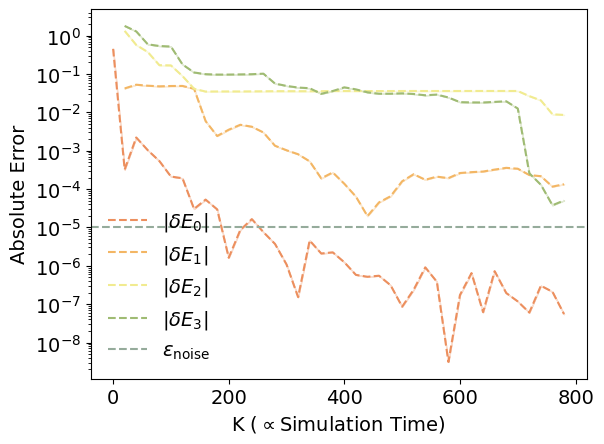

In [11]:
# Plotting
algorithm = 'ODMD'
colors = get_color_set('N2')
labels = [r'$|\delta E_0|$',r'$|\delta E_1|$',r'$|\delta E_2|$',r'$|\delta E_3|$']
matplotlib.rcParams.update({'font.size': 14})

for energy_level in range(max_energy_level+1):

    if algorithm == 'ODMD':
        odmd_average = np.average(absolute_odmd_errors,0)[:,energy_level]
        odmd_std = np.std(absolute_odmd_errors,0)[:,energy_level]
        plt.semilogy(K_values, odmd_average, '--',color = colors[energy_level],label = labels[energy_level])
        plt.fill_between(K_values,odmd_average,odmd_average + odmd_std,color = colors[energy_level],alpha = .3)
        
    elif algorithm == 'MODMD':
        modmd_average = np.average(absolute_modmd_errors,0)[:,energy_level]
        modmd_std = np.std(absolute_modmd_errors,0)[:,energy_level]
        plt.semilogy(K_values,modmd_average,color = colors[energy_level],label = labels[energy_level])
        plt.fill_between(K_values,modmd_average,modmd_average + modmd_std,color = colors[energy_level],alpha = .3)

plt.axhline(epsilon, color = '#95ab9b', linestyle = '--', label = r'$\epsilon_\text{noise}$')
plt.xlabel(r'K ($\propto \text{Simulation Time})$')
plt.ylabel(r'Absolute Error')
plt.legend(fontsize=14, framealpha = 0)